# Testing different experiment platforms

In [ ]:
%pip install sagemaker

### AWS Experiments

In [1]:
from torchvision import datasets, transforms
import sagemaker
from sagemaker.session import Session
from sagemaker.experiments.run import Run, load_run
from sagemaker.utils import unique_name_from_base
import torch
import os
import sys
import logging
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ra-ugrad/.config/sagemaker/config.yaml
local-experiment-example-1750265654-a98f


In [ ]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


experiment_name = unique_name_from_base("local-experiment-example")
run_name = "experiment-run"
print(experiment_name)

In [3]:
os.chdir('..')
import src.credentials as credentials
boto_session = boto3.Session(
    aws_access_key_id=credentials.ACCESS_KEY,
    aws_secret_access_key=credentials.SECRET_KEY,
    region_name="us-west-2"
)

session = Session(boto_session=boto_session)

In [11]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
datasets.MNIST.urls = [
    f"https://sagemaker-example-files-prod-{session.boto_region_name}.s3.amazonaws.com/datasets/image/MNIST/train-images-idx3-ubyte.gz",
    f"https://sagemaker-example-files-prod-{session.boto_region_name}.s3.amazonaws.com/datasets/image/MNIST/train-labels-idx1-ubyte.gz",
    f"https://sagemaker-example-files-prod-{session.boto_region_name}.s3.amazonaws.com/datasets/image/MNIST/t10k-images-idx3-ubyte.gz",
    f"https://sagemaker-example-files-prod-{session.boto_region_name}.s3.amazonaws.com/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz",
]

train_set = datasets.MNIST(
    "mnist_data",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

test_set = datasets.MNIST(
    "mnist_data",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 621kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.32MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.0MB/s]


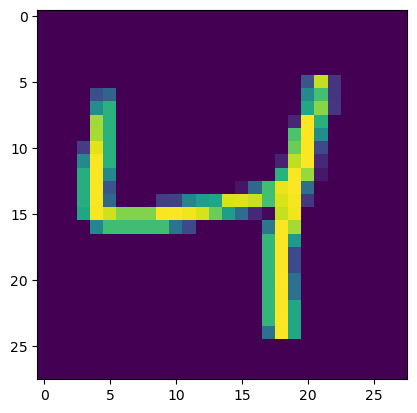

In [12]:
plt.imshow(train_set.data[2].numpy())

In [ ]:
%%time
# create an experiment and start a new run
with Run(experiment_name=experiment_name, run_name=run_name, sagemaker_session=session) as run:
    run.log_parameters(
        {"num_train_samples": len(train_set.data), "num_test_samples": len(test_set.data)}
    )
    for f in os.listdir(train_set.raw_folder):
        print("Logging", train_set.raw_folder + "/" + f)
        run.log_file(train_set.raw_folder + "/" + f, name=f, is_output=False)

INFO:sagemaker.experiments.run:The run (experiment-run) under experiment (local-experiment-example-1750262953-1bd1) already exists. Loading it.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/ra-ugrad/anaconda3/lib/python3.12/site-packages/IPython/core/magics/execution.py:1340 in   │
│ time                                                                                             │
│                                                                                                  │
│   1337 │   │   else:                                                                             │
│   1338 │   │   │   st = clock2()                                                                 │
│   1339 │   │   │   try:                                                                          │
│ ❱ 1340 │   │   │   │   exec(code, glob, local_ns)                                                │
│   1341 │   │   │   │   out=None                                                                  │
│   1342 │   │   │   │   # multi-line %%time case                                                  │
│   1343 │   │   │   │   if expr_val is not None:                                                  │
│ in <module>:3                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'Run' object has no attribute 'run_arn'

In [15]:
# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(torch.nn.Module):
    def __init__(self, hidden_channels, kernel_size, drop_out):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, hidden_channels, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv2d(hidden_channels, 20, kernel_size=kernel_size)
        self.conv2_drop = torch.nn.Dropout2d(p=drop_out)
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x), 2))
        x = torch.nn.functional.relu(
            torch.nn.functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2)
        )
        x = x.view(-1, 320)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.nn.functional.log_softmax(x, dim=1)

In [24]:
def log_performance(model, data_loader, device, epoch, run, metric_type="Test"):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    loss /= len(data_loader.dataset)
    accuracy = 100.0 * correct / len(data_loader.dataset)
    # log metrics
    run.log_metric(name=metric_type + ":loss", value=loss, step=epoch)
    run.log_metric(name=metric_type + ":accuracy", value=accuracy, step=epoch)


def train_model(
    run, train_set, test_set, data_dir="mnist_data", optimizer="sgd", epochs=10, hidden_channels=10
):
    """
    Function that trains the CNN classifier to identify the MNIST digits.
    Args:
        run (sagemaker.experiments.run.Run): SageMaker Experiment run object
        train_set (torchvision.datasets.mnist.MNIST): train dataset
        test_set (torchvision.datasets.mnist.MNIST): test dataset
        data_dir (str): local directory where the MNIST datasource is stored
        optimizer (str): the optimization algorthm to use for training your CNN
                         available options are sgd and adam
        epochs (int): number of complete pass of the training dataset through the algorithm
        hidden_channels (int): number of hidden channels in your model
    """

    # log the parameters of your model
    run.log_parameter("device", "cpu")
    run.log_parameters(
        {
            "data_dir": data_dir,
            "optimizer": optimizer,
            "epochs": epochs,
            "hidden_channels": hidden_channels,
        }
    )

    # train the model on the CPU (no GPU)
    device = torch.device("cuda:0")

    # set the seed for generating random numbers
    torch.manual_seed(42)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)
    model = Net(hidden_channels, kernel_size=5, drop_out=0.5).to(device)
    model = torch.nn.DataParallel(model)
    momentum = 0.5
    lr = 0.01
    log_interval = 100
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        print("Training Epoch:", epoch)
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader, 1):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        log_performance(model, train_loader, device, epoch, run, "Train")
        log_performance(model, test_loader, device, epoch, run, "Test")
    # log confusion matrix
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            run.log_confusion_matrix(target.cpu(), pred.cpu(), "Confusion-Matrix-Test-Data")

In [ ]:
%%time
with load_run(experiment_name=experiment_name, run_name=run_name, sagemaker_session=session) as run:
    train_model(
        run=run,
        train_set=train_set,
        test_set=test_set,
        epochs=3,
        hidden_channels=2,
        optimizer="adam",
    )

INFO:sagemaker.experiments.run:The run (experiment-run) under experiment (local-experiment-example-1750262953-1bd1) already exists. Loading it.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/ra-ugrad/anaconda3/lib/python3.12/site-packages/IPython/core/magics/execution.py:1340 in   │
│ time                                                                                             │
│                                                                                                  │
│   1337 │   │   else:                                                                             │
│   1338 │   │   │   st = clock2()                                                                 │
│   1339 │   │   │   try:                                                                          │
│ ❱ 1340 │   │   │   │   exec(code, glob, local_ns)                                                │
│   1341 │   │   │   │   out=None                                                                  │
│   1342 │   │   │   │   # multi-line %%time case                                                  │
│   1343 │   │   │   │   if expr_val is not None:                                                  │
│ in <module>:2                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'Run' object has no attribute 'run_arn'

In [27]:
%%time
# define the list of parameters to train the model with
num_hidden_channel_param = [5, 10]
optimizer_param = ["adam", "sgd"]
run_id = 0
# train the model using SageMaker Experiments to track the model parameters,
# metrics and performance
sm_session = session
for i, num_hidden_channel in enumerate(num_hidden_channel_param):
    for k, optimizer in enumerate(optimizer_param):
        run_id += 1
        run_name = "experiment-run-" + str(run_id)
        print(run_name)
        print(
            f"Training model with: {num_hidden_channel} hidden channels and {optimizer} as optimizer"
        )
        # Defining an experiment run for each model training run
        with Run(
            experiment_name=experiment_name, run_name=run_name, sagemaker_session=sm_session
        ) as run:
            train_model(
                run=run,
                train_set=train_set,
                test_set=test_set,
                epochs=3,
                hidden_channels=num_hidden_channel,
                optimizer=optimizer,
            )

experiment-run-1
Training model with: 5 hidden channels and adam as optimizer
Training Epoch: 1
Training Epoch: 2
Training Epoch: 3
experiment-run-2
Training model with: 5 hidden channels and sgd as optimizer
Training Epoch: 1
Training Epoch: 2
Training Epoch: 3
experiment-run-3
Training model with: 10 hidden channels and adam as optimizer
Training Epoch: 1
Training Epoch: 2
Training Epoch: 3
experiment-run-4
Training model with: 10 hidden channels and sgd as optimizer
Training Epoch: 1
Training Epoch: 2
Training Epoch: 3
CPU times: user 4min 48s, sys: 9.25 s, total: 4min 58s
Wall time: 5min 14s


Empty DataFrame
Columns: []
Index: []


### Weights & Biases

In [4]:
from sagemaker.pytorch import PyTorch

In [5]:
role = "arn:aws:iam::789817373659:role/service-role/AmazonSageMaker-ExecutionRole-20250601T001015" # retreived from SageMaker::UserProfile

In [6]:
estimator = PyTorch(entry_point='src/mnist_wb.py',
                    source_dir="src",
                    role=role,
                    py_version='py3',
                    framework_version='1.8.0',
                    instance_count=1,
                    instance_type='ml.c5.2xlarge',
                    hyperparameters={
                        'epochs': 1,
                        'backend': 'gloo'
                    },
                   # Pass Weights & Biases API Key as an environment variable
                   # You can find the key by going to https://wandb.ai/authorize
                   environment={"WANDB_API_KEY": credentials.WANDB_KEY})


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 estimator = PyTorch(entry_point='src/mnist_wb.py',                                          │
│    2 │   │   │   │   │   source_dir="src",                                                       │
│    3 │   │   │   │   │   role=role,                                                              │
│    4 │   │   │   │   │   py_version='py3',                                                       │
│                                                                                                  │
│ /home/ra-ugrad/anaconda3/lib/python3.12/site-packages/sagemaker/pytorch/estimator.py:394 in      │
│ __init__                                                                                         │
│                                                                                                  │
│   391 │   │   │   if self.framework_version and Version(self.framework_version) >= Version("1.   │
│   392 │   │   │   │   kwargs["enable_sagemaker_metrics"] = True                                  │
│   393 │   │                                                                                      │
│ ❱ 394 │   │   super(PyTorch, self).__init__(                                                     │
│   395 │   │   │   entry_point, source_dir, hyperparameters, image_uri=image_uri, **kwargs        │
│   396 │   │   )                                                                                  │
│   397                                                                                            │
│                                                                                                  │
│ /home/ra-ugrad/anaconda3/lib/python3.12/site-packages/sagemaker/estimator.py:3573 in __init__    │
│                                                                                                  │
│   3570 │   │   │   You can find additional parameters for initializing this class at             │
│   3571 │   │   │   :class:`~sagemaker.estimator.EstimatorBase`.                                  │
│   3572 │   │   """                                                                               │
│ ❱ 3573 │   │   super(Framework, self).__init__(enable_network_isolation=enable_network_isolatio  │
│   3574 │   │   image_uri = renamed_kwargs("image_name", "image_uri", image_uri, kwargs)          │
│   3575 │   │                                                                                     │
│   3576 │   │   validate_source_code_input_against_pipeline_variables(                            │
│                                                                                                  │
│ /home/ra-ugrad/anaconda3/lib/python3.12/site-packages/sagemaker/estimator.py:633 in __init__     │
│                                                                                                  │
│    630 │   │   │   │   │   "https://sagemaker.readthedocs.io/en/stable/overview.html#local-mode  │
│    631 │   │   │   │   )                                                                         │
│    632 │   │   else:                                                                             │
│ ❱  633 │   │   │   self.sagemaker_session = sagemaker_session or Session()                       │
│    634 │   │                                                                                     │
│    635 │   │   tags = format_tags(tags)                                                          │
│    636 │   │   self.tags = (                                                                     │
│                                                                                                  │
│ /home/ra-ugrad/anaconda3/lib/python3.12/site-packages/sagem